<a href="https://colab.research.google.com/github/sakib7/ml-project-versioning/blob/main/lstm_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [43]:
url = "https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/Sentiment140.tenPercent.sample.tweets.tsv"
dataset = pd.read_csv(url, delimiter="\t")
dataset['sentiment'] = dataset['sentiment_label'].replace(4,1)
dataset['text'] = dataset['tweet_text']
dataset = dataset.drop(columns=['tweet_text', 'sentiment_label'])
# print(dataset.head(10))
dataset

,sentiment,text
0,1,"@elephantbird Hey dear, Happy Friday to You A..."
1,1,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...
...,...,...
159995,0,STILL @ panera...studying for &quot;mock&quot;...
159996,0,Insomnia is out of control tonight--haven't sl...
159997,1,@Covergirl08 I take pride in what I do
159998,1,heading to work on the 6


In [44]:
# Reading contractions.csv and storing it as a dict.
contractions = pd.read_csv('https://raw.githubusercontent.com/sakib7/IT00CD79-3005-Machine-Learning/main/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'', tweet)

    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '', tweet)
    tweet = re.sub(smileemoji, '', tweet)
    tweet = re.sub(sademoji, '', tweet)
    tweet = re.sub(neutralemoji, '', tweet)
    tweet = re.sub(lolemoji, '', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    # tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [45]:
%%time
dataset['processed_text'] = dataset.text.apply(preprocess_apply)

CPU times: user 8.34 s, sys: 41.8 ms, total: 8.38 s
Wall time: 8.47 s


In [46]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: @elephantbird Hey dear, Happy Friday to You  Already had your rice's bowl for lunch ?
Processed:  hey dear  happy friday to you  already had your riceis bowl for lunch  
Text: Ughhh layin downnnn    Waiting for zeina to cook breakfast
Processed: ughh layin downn  waiting for zeina to cook breakfast
Text: @greeniebach I reckon he'll play, even if he's not 100%...but i know nothing!! ;) It won't be the same without him. 
Processed:  i reckon he will play  even if he is not 100   but i know nothing    it will not be the same without him  
Text: @vaLewee I know!  Saw it on the news!
Processed:  i know   saw it on the news 
Text: very sad that http://www.fabchannel.com/ has closed down. One of the few web services that I've used for over 5 years 
Processed: very sad that  has closed down  one of the few web services that i have used for over 5 years 
Text: @Fearnecotton who sings 'I Remember'? i alwaysss hear it on Radio 1 but never catch the artist 
Processed:  who sings  i remember 

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [49]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [50]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 vector_size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 13700
CPU times: user 20.6 s, sys: 150 ms, total: 20.8 s
Wall time: 12.4 s


In [51]:
# Defining the model input length.
input_length = 60

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [52]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)
tokenizer.word_index['love']

Tokenizer vocab length: 60000


48

In [54]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(X_train[10:15])
print(X_train_sequences[10:15])

[' yet again  a diss goes rght past u dork   and how the hell did u get more followers  meanie'
 'i have a sad feeling that dallas is not going to show up  i got to say though  you would think more shows would use music from the game  mm'
 '  glad to hear that you have great friends kyanna  im sorry to hear about your family'
 'what am i going to do  my ipod is dying     nowhere near a charger'
 ' they are trying to confuse you  and it seems to work  ']
[[209, 107, 5, 9796, 518, 28318, 725, 55, 4154, 8, 69, 4, 449, 67, 55, 37, 86, 385, 5197], [2, 16, 5, 111, 181, 20, 2606, 6, 11, 34, 3, 171, 33, 2, 42, 3, 166, 129, 10, 101, 78, 86, 837, 101, 357, 326, 54, 4, 305, 647], [270, 3, 263, 20, 10, 16, 100, 198, 48127, 60, 119, 3, 263, 59, 46, 337], [57, 15, 2, 34, 3, 23, 7, 622, 6, 998, 2083, 1006, 5, 2198], [75, 26, 222, 3, 6485, 10, 8, 9, 486, 3, 47]]


In [55]:
X_train = pad_sequences(X_train_sequences, maxlen=input_length)
X_test  = pad_sequences(X_test_sequences , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
X_train[10], X_test[10]

X_train.shape: (152000, 60)
X_test.shape : (8000, 60)


(array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   209,   107,     5,  9796,
          518, 28318,   725,    55,  4154,     8,    69,     4,   449,
           67,    55,    37,    86,   385,  5197], dtype=int32),
 array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,    40,  2958, 38910], dtype=int32))

In [56]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)
embedding_matrix[50]

Embedding Matrix Shape: (60000, 100)


array([ 0.63257104, -0.87901872,  0.86834019, -0.36941704, -0.07930303,
       -0.14659999,  1.27091324, -0.23722528,  0.69779456, -0.33709592,
        0.42027131,  0.10262145,  0.46359912,  0.3701998 ,  0.78182632,
        1.40531206, -0.11152039, -0.27903289,  0.11871244, -0.72470051,
        1.13771415, -1.07927608,  0.47920045, -0.82021934, -0.3466059 ,
       -0.61190552, -1.22144067, -0.50051332, -0.50178599, -1.0881772 ,
        0.35898751,  0.30385181,  1.13847888, -0.17573202, -0.37698132,
        0.30996516,  0.62975556,  0.13973114,  0.50061148, -0.79986894,
       -0.05048239,  1.62474394, -0.82168627, -0.04625425, -0.26610142,
       -0.13651834, -1.00015891,  0.96215951,  0.62396872,  0.65252388,
       -0.43382639,  0.2274019 ,  0.11630802,  0.06975469,  0.09902438,
        0.38526604,  0.44678876, -0.21910703, -0.10810551,  0.62419653,
        0.38995427,  0.51270705, -0.42712346, -0.35651782,  0.40039212,
       -0.25615904, -0.40919548,  0.59328771, -1.11105764, -0.01

In [57]:
from keras import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [58]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        LSTM(64, dropout=0.3, return_sequences=True),
        # Bidirectional(LSTM(64, dropout=0.3, return_sequences=True)),
        # Conv1D(64, 5, activation='relu'),
        GlobalMaxPool1D(),
        # Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model


In [59]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 100)           6000000   
                                                                 
 lstm_2 (LSTM)               (None, 60, 64)            42240     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6042305 (23.05 MB)
Trainable params: 42305 (165.25 KB)
Non-trainable params: 6000000 (22.89 MB)
_________________________________________________________________


In [60]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [61]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/7
268/268 [==============================] - 72s 261ms/step - loss: 0.5529 - accuracy: 0.7154 - val_loss: 0.5017 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 2/7
268/268 [==============================] - 70s 261ms/step - loss: 0.5072 - accuracy: 0.7500 - val_loss: 0.4822 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 3/7
268/268 [==============================] - 67s 250ms/step - loss: 0.4916 - accuracy: 0.7612 - val_loss: 0.4755 - val_accuracy: 0.7692 - lr: 0.0010
Epoch 4/7
268/268 [==============================] - 66s 248ms/step - loss: 0.4827 - accuracy: 0.7673 - val_loss: 0.4679 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 5/7
268/268 [==============================] - 66s 247ms/step - loss: 0.4740 - accuracy: 0.7719 - val_loss: 0.4615 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 6/7
268/268 [==============================] - 69s 257ms/step - loss: 0.4675 - accuracy: 0.7765 - val_loss: 0.4567 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 7/7
268/268 [==============================] - 69s 2

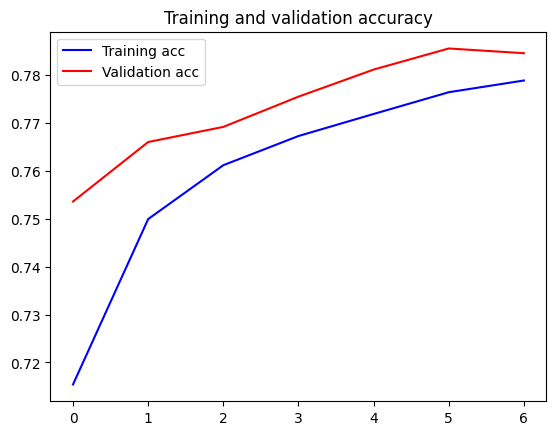

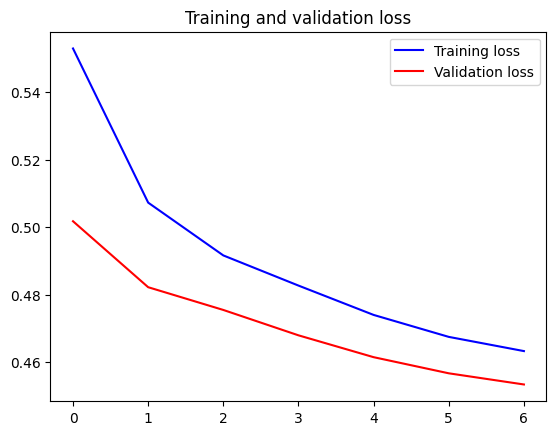

250/250 [==============================] - 3s 12ms/step
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      4061
           1       0.79      0.79      0.79      3939

    accuracy                           0.79      8000
   macro avg       0.79      0.79      0.79      8000
weighted avg       0.79      0.79      0.79      8000

CPU times: user 12min 25s, sys: 23.5 s, total: 12min 49s
Wall time: 8min 2s


In [62]:
%%time

history = training_model.fit(
    X_train, y_train,
    batch_size=512,
    epochs=7,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

from sklearn.metrics import confusion_matrix, classification_report

y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

print(classification_report(y_test, y_pred))